In [263]:
# TODO: Try Data Augmentation on the Malignant Data to increase the sample
# TODO: Look at the AUC ROC Curve

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

## 1. Review Dataset and Load Images

### 1.1 Limit GPU Memory Growth

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### 1.2 Collecting Images from Data Folder

In [73]:
dataset = tf.data.Dataset.list_files("data\\*jpg", shuffle = False)

### 1.3 Loading the Images (Resize/Rescale)

In [74]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)

    # Resize the images
    img = tf.image.resize(img/255, [512,512])
    return img

In [75]:
dataset = dataset.map(load_image)

In [76]:
dataset.as_numpy_iterator().next().shape

(512, 512, 3)

### 1.4 Viewing the Raw Images

In [77]:
image_generator = dataset.batch(4).as_numpy_iterator()

In [78]:
plot_images = image_generator.next()

In [79]:
plot_images[0].shape

(512, 512, 3)

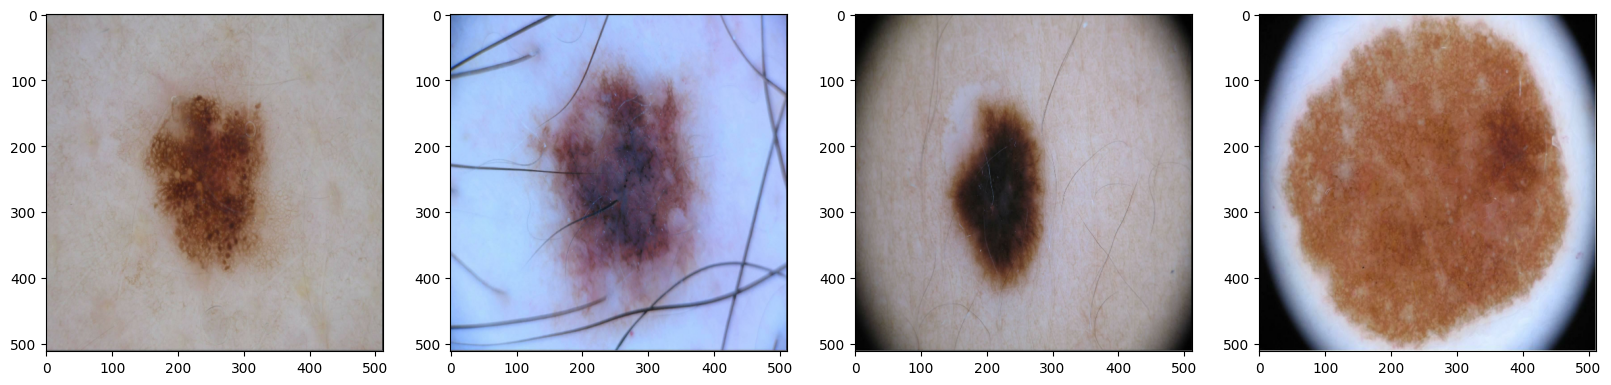

In [80]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 2. Partition Data and Into Labels Folders

In [3]:
import pandas as pd
import os

### 2.1 Read from metadata

In [83]:
metadata = pd.read_csv("data\\metadata.csv")

In [86]:
img_label_df = metadata[["isic_id", "benign_malignant"]]

In [87]:
img_label_df

,isic_id,benign_malignant
0,ISIC_0000017,benign
1,ISIC_0000042,benign
2,ISIC_0000048,benign
3,ISIC_0000075,benign
4,ISIC_0000170,malignant
...,...,...
6864,ISIC_9997614,benign
6865,ISIC_9998582,benign
6866,ISIC_9998965,benign
6867,ISIC_9999134,benign


### 2.2 Creating Training, Validation, and Testing DataFrames

In [96]:
from sklearn.model_selection import train_test_split

In [100]:
train_df, test_df = train_test_split(img_label_df, train_size=0.80)
val_df, test_df = train_test_split(test_df, test_size=0.50)

### 2.3 Iterate through DataFrames to Partition Data

In [105]:
# Iterate through the training data
for index, row in train_df.iterrows():
    image = row["isic_id"]+".JPG"
    label = row["benign_malignant"]
    image_path = os.path.join("data", image)
    if os.path.exists(image_path):
        new_filepath = os.path.join("train", label, image)
        os.replace(image_path, new_filepath)

In [106]:
# Iterate through the validation data
for index, row in val_df.iterrows():
    image = row["isic_id"]+".JPG"
    label = row["benign_malignant"]
    image_path = os.path.join("data", image)
    if os.path.exists(image_path):
        new_filepath = os.path.join("val", label, image)
        os.replace(image_path, new_filepath)

In [107]:
# Iterate through the testing data
for index, row in test_df.iterrows():
    image = row["isic_id"]+".JPG"
    label = row["benign_malignant"]
    image_path = os.path.join("data", image)
    if os.path.exists(image_path):
        new_filepath = os.path.join("test", label, image)
        os.replace(image_path, new_filepath)

## Image Augmentation on the Malignant Training Data

### Creating Directory for the augmented training images

In [25]:
# os.makedirs("aug_train\\malignant")

### Creating Augmentor

In [187]:
import albumentations as A

In [188]:
augmentor = A.Compose([A.HorizontalFlip(p = 0.5),
                       A.RandomBrightnessContrast(p = 0.2),
                       A.RandomGamma(p = 0.2),
                       A.RGBShift(p = 0.2),
                       A.VerticalFlip(p = 0.5)])

### Test Augmentor on Random Image

In [30]:
example_image_path = "C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\melanoma_detection\\train\\malignant\\ISIC_0000170.JPG"
example_image = cv2.imread(example_image_path)

In [31]:
example_augmented_image = augmentor(image = example_image)

### Visualize Augmented Image

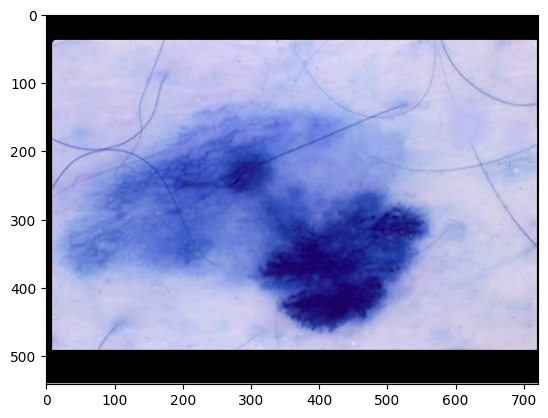

In [34]:
plt.imshow(example_augmented_image["image"])

### Create Augmentation Pipeline on Training Malignant Data

In [195]:
for image in os.listdir(os.path.join("train", "malignant")):
    img = cv2.imread(os.path.join("train", "malignant", image))

    try:
        for x in range(9):
            augmented_image = augmentor(image = img)
            augmented_image = augmented_image["image"]
            output_path = os.path.join("aug_train", "malignant", f"{image}_{x+28}.JPG")
            cv2.imwrite(output_path, augmented_image)
    except Exception as e:
        print(e)

KeyboardInterrupt: 

## 3 Create tf.data.Datasets using the Directory 

### 3.1 Create Datasets from Directory

In [196]:
def process(image, label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

In [197]:
# Create Train Dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(directory="aug_train",
                                                            labels = "inferred",
                                                            label_mode = "binary",
                                                            class_names = ["benign", "malignant"],
                                                            batch_size = 16,
                                                            image_size = (512,512),
                                                            shuffle = True)
train_dataset = train_dataset.map(process)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

Found 36403 files belonging to 2 classes.


In [198]:
# Create Validation Dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(directory="val",
                                                            labels = "inferred",
                                                            label_mode = "binary",
                                                            class_names = ["benign", "malignant"],
                                                            batch_size = 16,
                                                            image_size = (512,512),
                                                            shuffle = False)
val_dataset = val_dataset.map(process)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Found 687 files belonging to 2 classes.


In [199]:
test_dataset = tf.keras.utils.image_dataset_from_directory(directory="test",
                                                            labels = "inferred",
                                                            label_mode = "binary",
                                                            class_names = ["benign", "malignant"],
                                                            batch_size = 16,
                                                            image_size = (512,512),
                                                            shuffle = False)
test_dataset = test_dataset.map(process)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Found 687 files belonging to 2 classes.


### 3.2 Check Lengths of Partitions

In [200]:
len(train_dataset), len(val_dataset), len(test_dataset)

(2276, 43, 43)

## 4. Visualizing the Training Data with Labels

### 

### 4.1 Collecting Train Samples

In [201]:
class_names = {
    "0.0" : "benign",
    "1.0" : "malignant"
}

In [202]:
train_samples = train_dataset.as_numpy_iterator()

In [203]:
res = train_samples.next()

### 4.2 Visualizing Samples

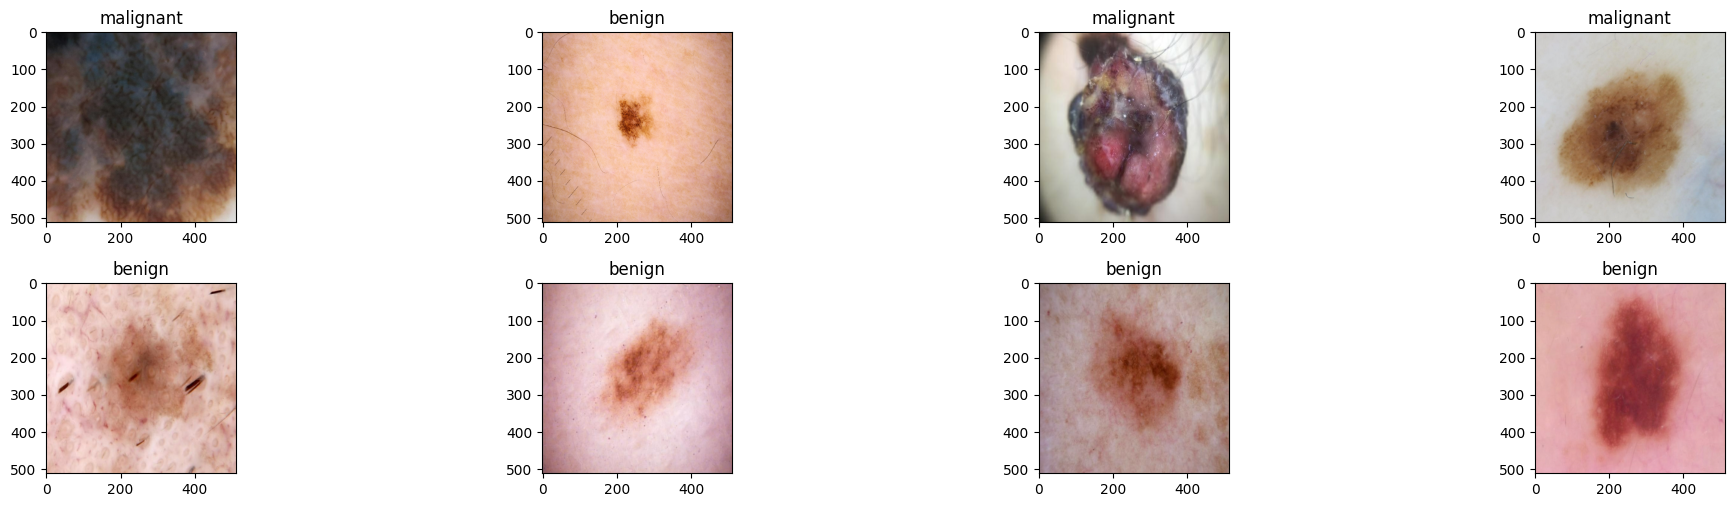

In [204]:
plt.figure(figsize = (20,20))

for i in range(8):
    ax = plt.subplot(8,4, i+1)

    image = res[0][i]
    label = res[1][i]

    label = class_names[str(label[0])]

    plt.imshow(image)
    ax.set_title(label)

plt.tight_layout()
plt.show()

## 5. Build CNN to Classify Melanoma Samples

In [205]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model

### 5.1 Functional API Convolutional Neural Network

In [206]:
def build_model():
    # Convolutional Blocks
    input_layer = Input(shape = (512,512,3))
    x = Conv2D(16, (3,3), activation = "relu") (input_layer)
    x = BatchNormalization() (x)
    x = MaxPooling2D((2,2)) (x)
    x = Dropout(0.25) (x)

    x = Conv2D(32, (3,3), activation = "relu") (x)
    x = MaxPooling2D((2,2)) (x)
    x = Dropout(0.25) (x)

    x = Conv2D(64, (3,3), activation = "relu") (x)
    x = BatchNormalization() (x)
    x = MaxPooling2D((2,2)) (x)
    x = Dropout(0.25) (x)

    # x = Dropout(0.25) (x)
    # x = Conv2D(256, (3,3), activation = "relu") (x)
    # x = MaxPooling2D((2,2)) (x)
    # x = Conv2D(512, (3,3), activation = "relu") (x)
    # x = BatchNormalization() (x)
    # x = MaxPooling2D((2,2)) (x)

    # Flatten
    x = Flatten() (x)

    # Dense Layers
    x = Dense(128, activation = "relu") (x)
    x = BatchNormalization() (x)
    x = Dropout(0.5) (x)
    conv_output = Dense(1, activation = "sigmoid") (x)

    conv_model = Model(input_layer, conv_output)

    return conv_model


In [207]:
conv_model = build_model()

In [208]:
conv_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 510, 510, 16)      448       
                                                                 
 batch_normalization_15 (Bat  (None, 510, 510, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 255, 255, 16)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 255, 255, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 253, 253, 32)      4640

### 5.2 Initializing Optimizers and Loss Functions

In [ ]:
batches_per_epoch = len(train_dataset)
lr_decay = (1/0.75 - 1)/batches_per_epoch

In [209]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = lr_decay)

In [210]:
loss = tf.keras.losses.BinaryCrossentropy()

### 5.3 Compile the Model

In [211]:
conv_model.compile(optimizer=opt, loss=loss, metrics = ["accuracy"])

### 5.4 Callbacks

In [212]:
# Tensorboard Callback
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [214]:
# Early Stopping Callback
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights=True
)

In [215]:
# Model Checkpoint Callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "melanoma_classification_model.h5",
    monitor = "val_loss",
    save_best_only = True,
    mode = "min",
    save_weights_only = False,
    save_freq = "epoch"
)

### 5.5 Training

In [216]:
hist = conv_model.fit(train_dataset, epochs = 40, validation_data=val_dataset, callbacks=[tensorboard_callback, es_callback, model_checkpoint_callback])

Epoch 1/40


2276/2276 [==============================] - 283s 124ms/step - loss: 0.5871 - accuracy: 0.7197 - val_loss: 0.3177 - val_accuracy: 0.8996
Epoch 2/40
2276/2276 [==============================] - 278s 122ms/step - loss: 0.5032 - accuracy: 0.7579 - val_loss: 0.2783 - val_accuracy: 0.9039
Epoch 3/40
2276/2276 [==============================] - 273s 120ms/step - loss: 0.4471 - accuracy: 0.7881 - val_loss: 0.3564 - val_accuracy: 0.8865
Epoch 4/40
2276/2276 [==============================] - 284s 124ms/step - loss: 0.4032 - accuracy: 0.8121 - val_loss: 0.3568 - val_accuracy: 0.8515
Epoch 5/40
2276/2276 [==============================] - 274s 120ms/step - loss: 0.3532 - accuracy: 0.8409 - val_loss: 0.3795 - val_accuracy: 0.9083
Epoch 6/40
2276/2276 [==============================] - 276s 121ms/step - loss: 0.3109 - accuracy: 0.8645 - val_loss: 0.2598 - val_accuracy: 0.9156
Epoch 7/40
2276/2276 [==============================] - 265s 116ms/step - loss: 0.2531 - accuracy: 0.8942 - val_loss: 0.368

## 6. Loading the Best Model

In [217]:
melanoma_classification_model = tf.keras.models.load_model("melanoma_classification_model.h5")

In [218]:
melanoma_classification_model.evaluate(test_dataset)

43/43 [==============================] - 6s 138ms/step - loss: 0.2846 - accuracy: 0.9243


[0.28458383679389954, 0.9243085980415344]

## 7. Making Predictions with Best Model

### 7.1 Testing Model to Make Predictions on Single Batch

In [219]:
# Test to see if it makes predictions
test_data = test_dataset.as_numpy_iterator()

In [220]:
test_sample = test_data.next()

In [221]:
y_hat = melanoma_classification_model.predict(test_sample[0])

1/1 [==============================] - 0s 279ms/step


In [222]:
y_hat

array([[3.8247363e-04],
       [8.9745987e-03],
       [1.2891066e-02],
       [8.8212878e-02],
       [4.8834911e-05],
       [1.5381868e-01],
       [2.8065440e-01],
       [1.8017761e-02],
       [5.0754186e-02],
       [1.9699511e-01],
       [7.9186162e-04],
       [2.9764429e-03],
       [1.0848584e-01],
       [1.8659404e-04],
       [1.4503710e-02],
       [2.3297973e-02]], dtype=float32)

### 7.2 Visualizing Predictions

[0.]
1/1 [==============================] - 0s 114ms/step
[0.]
1/1 [==============================] - 0s 77ms/step
[0.]
1/1 [==============================] - 0s 39ms/step
[0.]
1/1 [==============================] - 0s 35ms/step
[0.]
1/1 [==============================] - 0s 39ms/step
[0.]
1/1 [==============================] - 0s 38ms/step
[0.]
1/1 [==============================] - 0s 34ms/step
[0.]
1/1 [==============================] - 0s 36ms/step
[0.]
1/1 [==============================] - 0s 33ms/step
[0.]
1/1 [==============================] - 0s 36ms/step
[0.]
1/1 [==============================] - 0s 33ms/step
[0.]
1/1 [==============================] - 0s 35ms/step
[0.]
1/1 [==============================] - 0s 35ms/step
[0.]
1/1 [==============================] - 0s 35ms/step
[0.]
1/1 [==============================] - 0s 37ms/step
[0.]
1/1 [==============================] - 0s 35ms/step


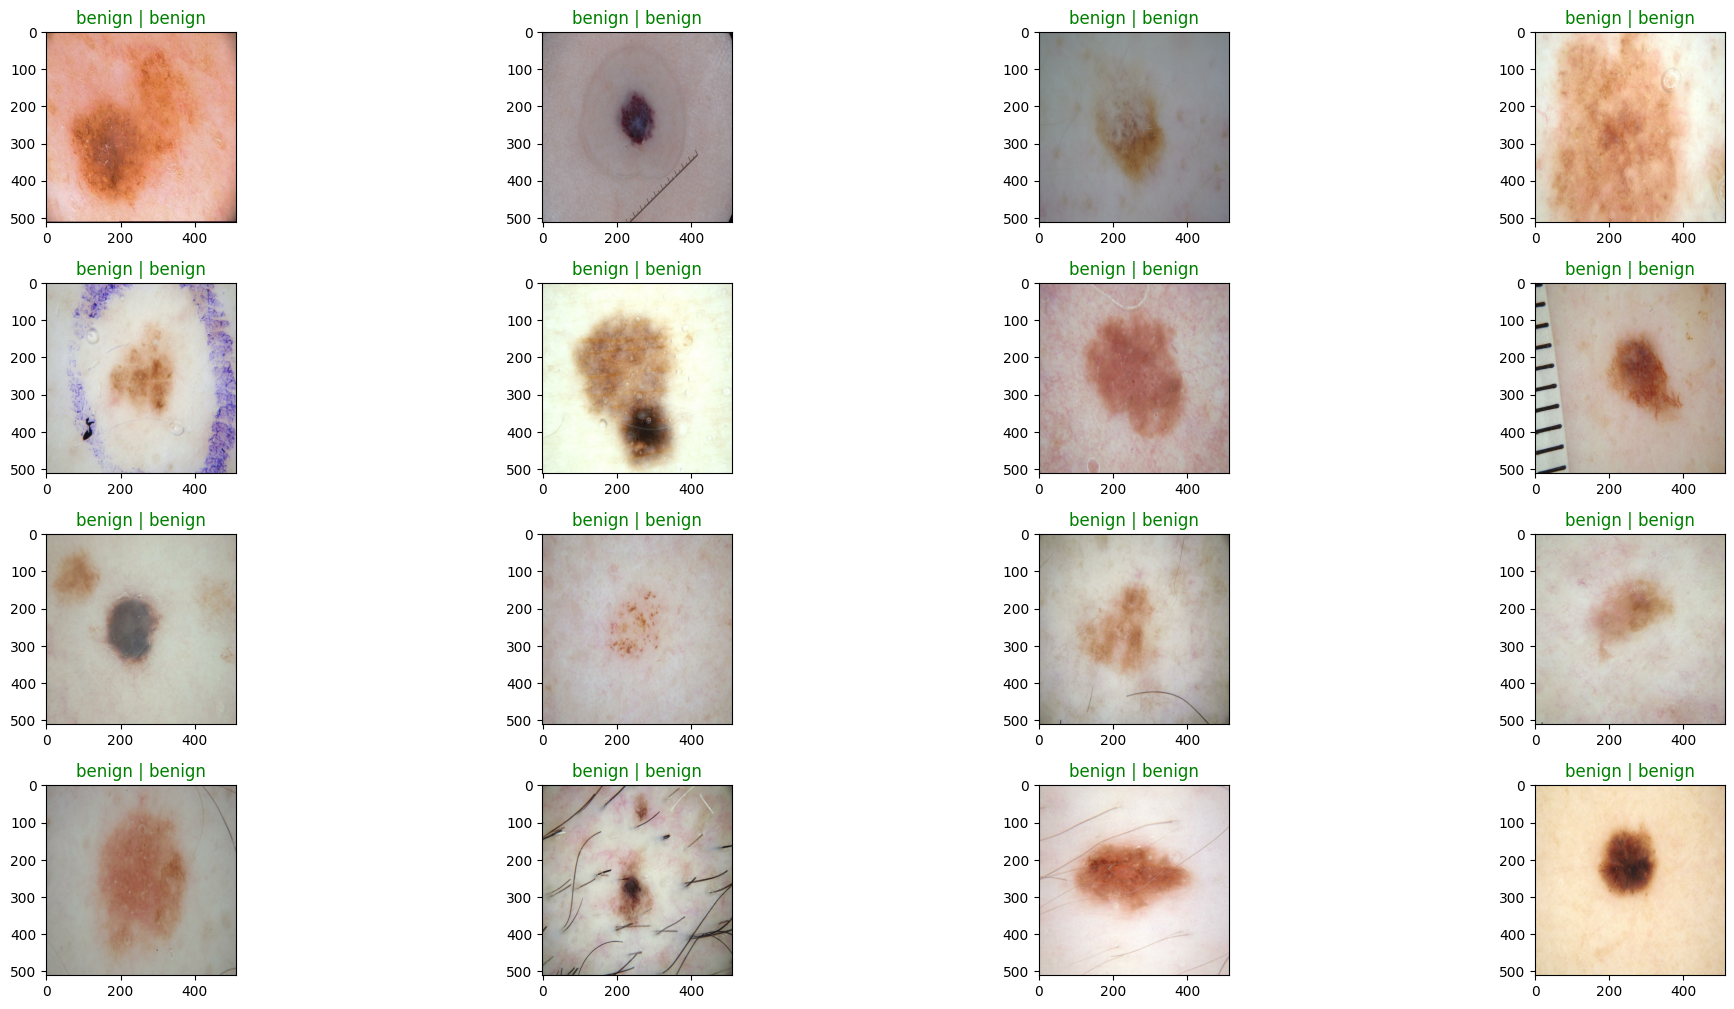

In [223]:
plt.figure(figsize = (20,20))

for i in range(16):
    ax = plt.subplot(8,4, i+1)

    image = test_sample[0][i]
    true_label = test_sample[1][i]
    print(true_label)

    pred_label = melanoma_classification_model.predict(test_sample[0])[i]
    if pred_label > 0.7:
        pred_label = "malignant"
    else:
        pred_label = "benign"
    true_label = class_names[str(true_label[0])]
    plt.imshow(image)
    if pred_label == true_label:
        ax.set_title(f"{true_label} | {pred_label}", color = "green")
    else:
        ax.set_title(f"{true_label} | {pred_label}", color = "red")

plt.tight_layout()
plt.show()

## 8. Evaluating the Model

### 8.1 Confusion Matrix

In [224]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

In [225]:
# y_test = test_dataset.map(lambda _, labels: labels)
_, labels = tuple(zip(*test_dataset.unbatch()))
labels = np.array(labels)
y_test = np.squeeze(labels, -1)

In [226]:
threshold_range = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
y_pred_probs = melanoma_classification_model.predict(test_dataset)
for threshold in threshold_range:
    y_pred_labels = (y_pred_probs >= threshold).astype(int)
    y_pred_labels = np.squeeze(y_pred_labels, -1)
    precision = precision_score(y_test, y_pred_labels)
    recall = recall_score(y_test, y_pred_labels)
    f1 = f1_score(y_test, y_pred_labels)
    # y_pred_labels = np.around(y_pred_probs)
    print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f}, | F1_Score: {f1:.4f}")
    

43/43 [==============================] - 5s 121ms/step
Threshold: 0.20 | Precision: 0.4507 | Recall: 0.5246, | F1_Score: 0.4848
Threshold: 0.30 | Precision: 0.5455 | Recall: 0.4918, | F1_Score: 0.5172
Threshold: 0.40 | Precision: 0.5682 | Recall: 0.4098, | F1_Score: 0.4762
Threshold: 0.50 | Precision: 0.6216 | Recall: 0.3770, | F1_Score: 0.4694
Threshold: 0.60 | Precision: 0.7000 | Recall: 0.3443, | F1_Score: 0.4615
Threshold: 0.70 | Precision: 0.7778 | Recall: 0.3443, | F1_Score: 0.4773
Threshold: 0.80 | Precision: 0.7692 | Recall: 0.3279, | F1_Score: 0.4598


In [231]:
# Change the threshold to view in confusion matrix
THRESHOLD = 0.30
y_pred_labels = (y_pred_probs >= THRESHOLD).astype(int)

In [232]:
y_test.shape, y_pred_labels.shape

((687,), (687, 1))

In [233]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

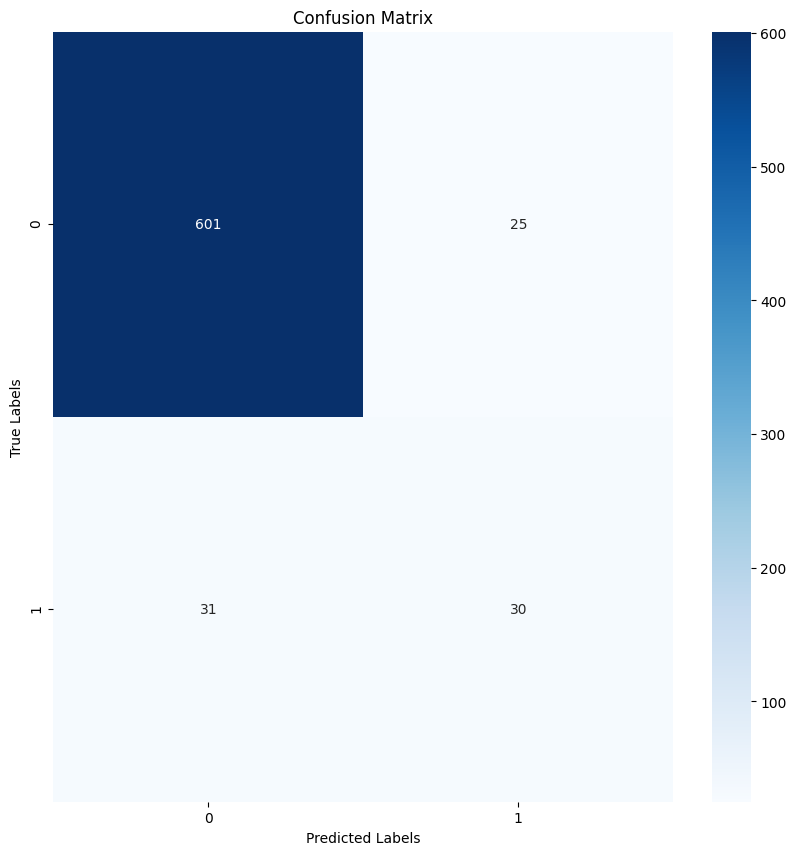

In [234]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()